# Вариационный автокодировщик

В задании предлагается реализовать вариационный и обычный автокодировщики, обучить их на MNIST, сравнить между собой эти модели, сделать выводы по результатам сравнения и выводы про каждую модель по отдельности.

Необходимая теория приведена ниже. Для более глубокого погружения в тему также есть список литературы с комментариями.

В этом задании нельзя использовать функций плотностей распределений, KL-дивергенцию и репараметризации из стандартных библиотек.

Актуальная версия доступна по адресу https://github.com/nadiinchi/dl_labs/blob/master/ht_vae/experiments.ipynb

## Теория

### Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

### Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. Сэмплируем $x \sim p_\theta(x | z)$.

Параметры распределения $p_\theta(x | z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$. Эта сеть называется генеративной сетью (generator) или декодером (decoder).

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z)$$

### Параметризация модели
Априорное распределение на скрытые перменные - стандартное нормальное распределение: $p(z) = \mathcal{N}(z | 0, I)$.

Распределения на компоненты $x$ условно независимы относительно $z$: $p_\theta(x | z) = \prod\limits_{i = 1}^D p_\theta(x_i | z)$.

Если i-ый признак объекта вещественный, то $p_\theta(x_i | z) = \mathcal{N}(x_i | \mu_i(z, \theta), \sigma^2_i(z, \theta))$.
Здесь $\mu(z, \theta)$ и $\sigma(z, \theta)$ - детерминированные функции, задаваемые нейросетями с параметрами $\theta$.

Если i-ый признак категориальный, то $p_\theta(x_i | z) = Cat(Softmax(\omega_i(z, \theta)))$, где $\omega_i(z, \theta)$ - тоже детерминированная функция задаваемая нейросетью.

Отдельно можно рассмотреть бинарные признаки, для которых категориальное распределение превращается в распределение Бернулли с одним параметром.

Подсказка: некоторые пиксели черные во всей обучающей выборке MNIST, поэтому максимизация правдоподибия будет заставлять модель уводить на бесконечность веса, соответствующие этим пикселям.
Чтобы избежать расходимости весов модели, можно переопределить модель таким образом, что для любой активации пикселя менее $\varepsilon$ или более $1 - \varepsilon$ она выдает вероятность этого пикселя равную $\varepsilon$ или $1 - \varepsilon$ соответственно.

### Вариационная нижняя оценка логарифма правдоподобия

Для максимизации правдоподобия максимизируем вариационную нижнюю оценку на логарифм правдоподобия:
$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x) = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z) q_\phi(z | x)}{q_\phi(z | x) p_\theta(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z)}{q_\phi(z | x)} + KL(q_\phi(z | x) || p_\theta(z | x))$$
$$\log p_\theta(x) \geqslant \mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x | z)p(z)}{q_\phi(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z) - KL(q_\phi(z | x) || p(z)) = L(x; \phi, \theta)
\to \max\limits_{\phi, \theta}$$

$q_\phi(z | x)$ называется предложным (proposal), распознающим (recognition) или вариационным (variational) распределением. Это гауссиана, чьи параметры задаются нейросетью с весами $\phi$:
$q_\phi(z | x) = \mathcal{N}(z | \mu_\phi(x), \sigma^2_\phi(x)I)$.
Обычно нейросеть моделирует не $\sigma_\phi(x)$, а $\log\sigma_\phi(x)$ или $\log(\exp(\sigma_\phi(x) - 1))$ или другую величину, более инвариантную к масштабу и определенную на всех вещественных числах так, чтобы $\sigma_\phi(x)$ было всегда положительным. В этом задании нужно использовать $\log(\exp(\sigma_\phi(x) - 1))$, поскольку обратное к нему преобразование softplus более стабильно, чем экспонента.

Зазор между вариационной нижней оценкой $L(x; \phi, \theta)$ на логарифм правдоподобия модели и самим логарифмом правдоподобия $\log p_\theta(x)$ - это KL-дивергенция между предолжным и апостериорным распределением на $z$: $KL(q_\phi(z | x) || p_\theta(z | x))$. Максимальное значение $L(x; \phi, \theta)$ при фиксированных параметрах модели $\theta$ достигается при $q_\phi(z | x) = p_\theta(z | x)$, но явное вычисление $p_\theta(z | x)$ требует слишком большого числа ресурсов, поэтому вместо этого вычисления вариационная нижняя оценка оптимизируется также по $\phi$. Чем ближе $q_\phi(z | x)$ к $p_\theta(z | x)$, тем точнее вариационная нижняя оценка.
Истинное апостериорное распределение $p_\theta(z | x)$ часто не может быть представлено одной гауссианой, поэтому зазор между нижней оценкой и логарифмом правдоподобия не достигает $0$. Тем не менее, есть статьи, утверждающие, что этот зазор практически не влияет на процесс оптимизации модели и его результат по сравнению с другими факторами (см. литературу).

Первое слагаемое вариационной нижней оценки $\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z)$ называется ошибкой восстановления (reconstruction loss).
Модель, соответствующая этой части - это автокодирощик с одним стохастическим слоем, пытающийся восстановить входной объект $x$.
Если распределение $q_\phi(z | x)$ - дельта-функция, то автокодировщик со стохастическим слоем превращается в обычный автокодировщик.
Поэтому $q_\phi(z | x)$ и $p_\theta(x | z)$ иногда называют энкодером и декодером соответственно.

Слагаемое $KL(q_\phi(z | x) || p(z))$ иногда называют регуляризатором.
Оно вынуждает $z \sim q_\phi(z | x)$ быть близким к $0$ и $q_\phi(z | x)$ быть близким к $p_\theta(z | x)$.
Иногда коэффициент при KL-дивергенции полагают не равным единице или даже используют другой регуляризатор.
Естественно, после этого обучение модели перестает соответствовать максимизации правдоподобия вышеописанной вероятностной модели данных.
Это существенно снижает интерпретируемость модели, устраняет теоретические гарантии для неё.
KL-дивергенция между двумя нормальными распределениями может быть вычислена аналитически.

Для максимизации $L(x; \phi, \theta)$ используется стохастический градиентный подъем.
Градиент ошибки восстановления по $\theta$ вычисляется с помощью метода обратного распространения ошибки.
$$\frac{\partial}{\partial \theta} L(x; \phi, \theta) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{\partial}{\partial \theta} \log p_\theta(x | z)$$

Градиент KL-дивергенции по $\phi$ может быть вычислен аналитически.
Для вычисления градиента ошибки восстановления по $\phi$ используется репараметризация (reparametrization trick):
$$\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)$$
$$z = \mu + \sigma \varepsilon \Rightarrow z \sim \mathcal{N}(z | \mu, \sigma^2I)$$
$$\frac{\partial}{\partial \phi} L(x; \phi, \theta) = \mathbb{E}_{\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)} \frac{\partial}{\partial \phi} \log p_\theta(x | \mu_\phi(x) + \sigma_\phi(x) \varepsilon) - \frac{\partial}{\partial \phi} KL(q_\phi(z | x) || p(z))$$

Подсказка: для выведения аналиической формулы KL-дивергенции между нормальными распределениями главное - никогда не писать знак интеграла. В задании рассматриваются только нормальные распределения с диагональной матрицей ковариации, поэтому достаточно вывести KL-дивергенцию между двумя одномерными нормальными распределениями. Все, что требуется для выведения формулы:
$$KL(q || p) = \mathbb{E}_{z \sim q} \log\frac{q(z)}{p(z)}$$
$$\log \mathrm{N}(z | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left(-\frac{(z - \mu)^2}{2\sigma^2} \right)$$
$$\mathbb{E}_{z \sim N(\mu, \sigma)}z = \mu$$
$$\mathbb{E}_{z \sim N(\mu, \sigma)}z^2 = \mu^2 + \sigma ^ 2$$
Кстати, у трех последних формул есть часто используемые многомерные обощения.

### Оценка правдоподобия модели

Правдоподобие модели $p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z)$ оценивают на отложенной выборке.

Оценка может быть получена с помощью метода Монте-Карло:

$$z_i \sim p(z), i = 1, \dots, K$$
$$p_\theta(x) \approx \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(x | z_i)$$

Альтернативный способ оценки - метод importance sampling. В качестве предложного распределения метода используется предложное распределение модели. Известно, что хороший выбор предложного распределения уменьшает дисперсию оценки. Для вариационных автокодировщиков оценки Монте-Карло, основанные на малом числе сэмплов, обычно занижены. Поэтому imporatance sampling также позволяет получить более высокую и точную оценку правдоподобия с помощью меньшего числа сэмплов.

$$z_i \sim q_\phi(z | x), i = 1, \dots, K$$
$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{p_\theta(x | z) p(z)}{q_\phi(z | x)} \approx \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)}$$

Для оценки логарифма правдоподобия усреднение вероятностей происходит под логарифмом:
$$\log p_\theta(x) \approx \log \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(x | z_i),\,\,\,\,z_i \sim p(z)$$
$$\log p_\theta(x) \approx \log \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)},\,\,\,\,z_i \sim q_\phi(z | x)$$
Заметим, что оценки логарифма правдоподобия уже не являются несмещенными, в отличие от оценок самого правдоподобия.
Несмотря на это, первую оценку все равно обычно называют оценкой Монте-Карло логарифма правдоподобия.
Вторая оценка известна в литературе как IWAE оценка по названию модели Importance Weighted Variational Autoencoders, в которой предлагается напрямую оптимизировать эту оценку правдоподобия для обучения автокодировщика.

### Литература
1. Auto-Encoding Variational Bayes https://arxiv.org/pdf/1312.6114.pdf, Stochastic Backpropagation and Approximate Inference in Deep Generative Models https://arxiv.org/pdf/1401.4082.pdf - оригинальные статьи про вариационный автокодировщик (две группы авторов независимо и почти одновременно предложили одинаковые модели).
2. Learning Structured Output Representation using Deep Conditional Generative Models https://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models.pdf - обусловленный вариационный автокодировщик для генерации из обусловленного распределения на объекты.
3. Importance Weighted Autoencoders https://arxiv.org/pdf/1509.00519.pdf - вариационный автокодировщик, оптимизирующий более точную нижнюю оценку на логарифм правдоподобия.
4. Tighter Variational Bounds are Not Necessarily Better https://arxiv.org/pdf/1802.04537.pdf - статья, показывающая, что предыдущая статья ухудшает обучение предложной сети автокодировщика как следствие более хорошей нижней оценки, и предлагающая способы решения этой проблемы.
5. Variational Inference with Normalizing Flows https://arxiv.org/pdf/1505.05770.pdf, Improved Variational Inference with Inverse Autoregressive Flow http://papers.nips.cc/paper/6581-improved-variational-inference-with-inverse-autoregressive-flow.pdf - более богатые семейства предложных распредлений.
6. VAE with a VampPrior https://arxiv.org/pdf/1705.07120.pdf - обучение априорного распределения на скрытые представления совместно с предложным. Улучшает правдоподобие модели, но делает менее интерпретируемым скрытое пространство.
7. Ladder Variation Autoencoders http://papers.nips.cc/paper/6275-ladder-variational-autoencoders.pdf - теперь у каждого объекта есть не одно скрытое представление, а несколько организованных в иерархию.
8. Inference Suboptimality in Variational Autoencoders https://arxiv.org/pdf/1801.03558.pdf - утверждает, что отличие предложного распределения от истинного апостериорного распределения в скрытом пространстве вызваны недостаточной выразительностью предложной сети, а не бедным семейством предложных распределений. Богатое же семейство предложных моделей снижает требования к выразительности предложной сети.

## Практика

### Загрузка, предобработка и визуалиация данных

In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch

from torch import nn
from torch.nn import functional as F
from torch import optim

import math

In [2]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

C:\Apps\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Apps\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Apps\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Apps\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


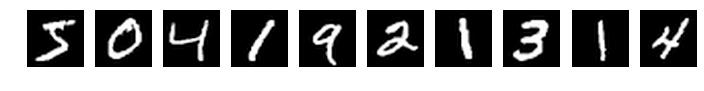

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 28, 28)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

Для корректности вероятностной модели исходное изображение также должно быть бинаризовано.

Бинаризация может производиться как округлением данных в датасете, так и сэмплированием из распределения Бернулли каждого пикселя. Округление приводит к более гладким фигурам в обучающей выборке, поэтому будем использовать его.

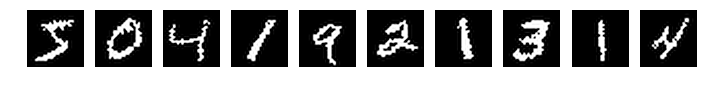

In [4]:
show_images(torch.bernoulli(train_data[:10][0]))

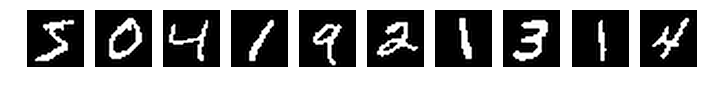

In [5]:
show_images(train_data[:10][0].round())

In [6]:
train_data.tensors = (train_data.tensors[0].round(), train_data.tensors[1])
test_data.tensors = (test_data.tensors[0].round(), test_data.tensors[1])

### Вспомогательные функции для обучения и тестирования

In [7]:
def model_test_loss(compute_loss, batch_size=100, max_batches=None, verbose=False):
    """
    Функция вычисляет усредненное значение функции потерь по тестовым данным.
    Вход: compute_loss, функция, принимающая батч в виде матрицы torch.FloatTensor
    и возвращающая float - функцию потерь на батче.
    Вход: batch_size, int.
    Вход: max_batches, int - если задано, включает режим оценки функции потерь
    с помощью сэмплирования батчей вместо полного прохода по данным и указывает,
    после какого батча прекратить вычисления.
    Вход: verbose, bool - указывает, печатать ли текущее состояние в процессе работы.
    Возвращаемое значение: float - оценка функции потерь на тестовых данных.
    """
    dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=(max_batches is None))
    num_batches = len(dataloader)
    avg_loss = 0
    for i, (batch, _) in enumerate(dataloader):
        loss = compute_loss(batch)
        avg_loss += (loss - avg_loss) / (i + 1)
        if verbose and (i + 1) % 10 == 0:
            print('\rTest loss:', avg_loss,
                  'Batch', i + 1, 'of', num_batches, ' ' * 10, end='', flush=True)
        if verbose and (i + 1) % 100 == 0:
            print(flush=True)
        if max_batches and i >= max_batches:
            break
    return avg_loss

In [8]:
def train_model(model, tests=[], batch_size=100, num_epochs=5, learning_rate=1e-3, maximization=True):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: tests - список тестов, выполняемых после каждого 100-го батча.
    Каждый элемент списка - словарь с полями 'name' - уникальным идентификатором
    теста и 'func' - функцией от модели.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'train_losses_list' - список функций потерь на каждом батче и 
    'test_results' - список результатов тестирования. Каждый результат
    тестирования - словарь вида name: value, где name - имя теста,
    value - результат его выполнения.
    """
    gd = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(dataloader):
            total = len(dataloader)
            loss = model.batch_loss(batch)
            if maximization:
                (-loss).backward()
            else:
                loss.backward()
            train_losses.append(float(loss))
            if (i + 1) % 100 == 0:
                print('Train loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 100, end='')
            if (i + 1) % 100 == 0:
                cur_test_result = {}
                for test in tests:
                    cur_test_result[test['name']] = test['func'](model)
                test_results.append(cur_test_result)
                print(flush=True)
            gd.step()
            gd.zero_grad()
    return {
        'model': model,
        'train_losses_list': train_losses,
        'test_results': test_results
    }

In [9]:
n = 15
digit_size = 28

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

In [10]:
def draw_latent_space(data, target, encoder):
    z_test = encoder(data)
    plt.figure(figsize=(7, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=target, cmap='gist_rainbow', alpha=0.75)
    plt.colorbar()
    plt.show()

In [11]:
from sklearn.manifold import TSNE

## Обычный автокодировщик

In [12]:
class AE(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.encoder = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.d)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            nn.Sigmoid()
        )

    def encode(self, x):
        """
        Генерирует код по объектам.
        Вход: x, Tensor - матрица размера n x D.
        Возвращаемое значение: Tensor - матрица размера n x d.
        """
        
        return torch.tensor(self.encoder(x))
        

    def decode(self, z):
        """
        По матрице латентных представлений z возвращает матрицу объектов x.
        Вход: z, Tensor - матрица n x d латентных представлений.
        Возвращаемое значение: Tensor, матрица объектов n x D.
        """
        return self.decoder(z)

    def batch_loss(self, batch):
        """
        Вычисляет функцию потерь по батчу - усреднение функции потерь
        по объектам батча.
        Функция потерь по объекту- сумма L2-ошибки восстановления по батчу и
        L2 регуляризации скрытых представлений с весом 1.
        Возвращаемое значение должно быть дифференцируемо по параметрам модели (!).
        Вход: batch, Tensor - матрица объектов размера n x D.
        Возвращаемое значение: Tensor, скаляр - функция потерь по батчу.
        """
        #print(1)
        
        x = self.encode(batch)
        y = self.decode(x)
        k = x*x
        z = (y-batch)**2
        #print(criterion(y-batch))
        #print(x.sum()/x.size()[0])
        loss =  z.mean() + k.mean()
        return loss

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы объектов x. Использует стандартное нормальное
        распределение в пространстве представлений.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x D.
        """
        z = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(self.d), torch.eye(self.d) )
        b = z.rsample(sample_shape = [1,num_samples]).squeeze(0)
        #return torch.bernoulli(self.decoder(torch.randn([num_samples, self.d], requires_grad=True)))
       
        return self.decoder(b)


### Обучение моделей

In [13]:
ae_tests = [
    {
        'name': 'test_loss',
        'func': lambda model:
                model_test_loss(lambda batch:
                                float(model.batch_loss(batch)),
                                max_batches=20)
    }
]

In [14]:
model = AE(2,784)

In [15]:
 dataloader = DataLoader(train_data, batch_size=2, shuffle=True)

In [61]:
c = next(iter(dataloader))

In [62]:
type(c[0])

torch.Tensor

In [63]:
b =  model.encoder(c[0])

In [64]:
loss = model.batch_loss(c[0])

C:\Apps\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [65]:
print(loss)

tensor(0.2659, grad_fn=<AddBackward0>)


In [16]:
%time
%reload_ext autoreload
ae_model_d2 = train_model(AE(2, 784), tests=ae_tests, maximization=False, num_epochs=50)

Wall time: 0 ns


C:\Apps\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss: 0.0911579504609108 Batch 100 of 600                                                                                                     
Train loss: 0.08825613558292389 Batch 200 of 600                                                                                                     
Train loss: 0.08596529811620712 Batch 300 of 600                                                                                                     
Train loss: 0.08790674805641174 Batch 400 of 600                                                                                                     
Train loss: 0.08411576598882675 Batch 500 of 600                                                                                                     
Train loss: 0.08587919175624847 Batch 600 of 600                                                                                                     
Train loss: 0.08859843015670776 Batch 100 of 600                                                     

Train loss: 0.08482635766267776 Batch 100 of 600                                                                                                     
Train loss: 0.08547404408454895 Batch 200 of 600                                                                                                     
Train loss: 0.08514443784952164 Batch 300 of 600                                                                                                     
Train loss: 0.08850370347499847 Batch 400 of 600                                                                                                     
Train loss: 0.08897288143634796 Batch 500 of 600                                                                                                     
Train loss: 0.08707468956708908 Batch 600 of 600                                                                                                     
Train loss: 0.08771120011806488 Batch 100 of 600                                                    

Train loss: 0.08835546672344208 Batch 100 of 600                                                                                                     
Train loss: 0.08802292495965958 Batch 200 of 600                                                                                                     
Train loss: 0.09048987179994583 Batch 300 of 600                                                                                                     
Train loss: 0.08633691817522049 Batch 400 of 600                                                                                                     
Train loss: 0.08721963316202164 Batch 500 of 600                                                                                                     
Train loss: 0.0905391275882721 Batch 600 of 600                                                                                                     
Train loss: 0.08890403807163239 Batch 100 of 600                                                     

Train loss: 0.09013144671916962 Batch 100 of 600                                                                                                     
Train loss: 0.09117341041564941 Batch 200 of 600                                                                                                     
Train loss: 0.08771676570177078 Batch 300 of 600                                                                                                     
Train loss: 0.08533929288387299 Batch 400 of 600                                                                                                     
Train loss: 0.0873640924692154 Batch 500 of 600                                                                                                     
Train loss: 0.08337558060884476 Batch 600 of 600                                                                                                     
Train loss: 0.0871887058019638 Batch 100 of 600                                                      

Train loss: 0.08580674231052399 Batch 100 of 600                                                                                                     
Train loss: 0.08467932045459747 Batch 200 of 600                                                                                                     
Train loss: 0.08580797910690308 Batch 300 of 600                                                                                                     
Train loss: 0.08441921323537827 Batch 400 of 600                                                                                                     
Train loss: 0.08469066023826599 Batch 500 of 600                                                                                                     
Train loss: 0.08687867224216461 Batch 600 of 600                                                                                                     
Train loss: 0.08450687676668167 Batch 100 of 600                                                    

Train loss: 0.08628755807876587 Batch 100 of 600                                                                                                     
Train loss: 0.08404329419136047 Batch 200 of 600                                                                                                     
Train loss: 0.08526729047298431 Batch 300 of 600                                                                                                     
Train loss: 0.09145672619342804 Batch 400 of 600                                                                                                     
Train loss: 0.08522868901491165 Batch 500 of 600                                                                                                     
Train loss: 0.0856521800160408 Batch 600 of 600                                                                                                     
Train loss: 0.08652898669242859 Batch 100 of 600                                                     

In [17]:
%time 
%reload_ext autoreload
ae_model_d10 = train_model(AE(10, 784), tests=ae_tests, maximization=False, num_epochs=50)

Wall time: 0 ns


C:\Apps\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss: 0.09715957194566727 Batch 100 of 600                                                                                                     
Train loss: 0.09260567277669907 Batch 200 of 600                                                                                                     
Train loss: 0.08777236938476562 Batch 300 of 600                                                                                                     
Train loss: 0.09321534633636475 Batch 400 of 600                                                                                                     
Train loss: 0.08706329762935638 Batch 500 of 600                                                                                                     
Train loss: 0.09049016237258911 Batch 600 of 600                                                                                                     
Train loss: 0.0871242955327034 Batch 100 of 600                                                     

Train loss: 0.07800275087356567 Batch 100 of 600                                                                                                     
Train loss: 0.07518119364976883 Batch 200 of 600                                                                                                     
Train loss: 0.08448098599910736 Batch 300 of 600                                                                                                     
Train loss: 0.07682092487812042 Batch 400 of 600                                                                                                     
Train loss: 0.07578911632299423 Batch 500 of 600                                                                                                     
Train loss: 0.07680752873420715 Batch 600 of 600                                                                                                     
Train loss: 0.07321545481681824 Batch 100 of 600                                                    

Train loss: 0.07400865107774734 Batch 100 of 600                                                                                                     
Train loss: 0.07886390388011932 Batch 200 of 600                                                                                                     
Train loss: 0.0794680267572403 Batch 300 of 600                                                                                                     
Train loss: 0.0790017694234848 Batch 400 of 600                                                                                                     
Train loss: 0.07977522164583206 Batch 500 of 600                                                                                                     
Train loss: 0.07825999706983566 Batch 600 of 600                                                                                                     
Train loss: 0.07710549980401993 Batch 100 of 600                                                      

Train loss: 0.07434780150651932 Batch 100 of 600                                                                                                     
Train loss: 0.07779871672391891 Batch 200 of 600                                                                                                     
Train loss: 0.07245554774999619 Batch 300 of 600                                                                                                     
Train loss: 0.07950273156166077 Batch 400 of 600                                                                                                     
Train loss: 0.07826896011829376 Batch 500 of 600                                                                                                     
Train loss: 0.07818722724914551 Batch 600 of 600                                                                                                     
Train loss: 0.07925049960613251 Batch 100 of 600                                                    

Train loss: 0.07642726600170135 Batch 100 of 600                                                                                                     
Train loss: 0.07050018012523651 Batch 200 of 600                                                                                                     
Train loss: 0.07373642921447754 Batch 300 of 600                                                                                                     
Train loss: 0.07667821645736694 Batch 400 of 600                                                                                                     
Train loss: 0.07457246631383896 Batch 500 of 600                                                                                                     
Train loss: 0.07736654579639435 Batch 600 of 600                                                                                                     
Train loss: 0.07812435925006866 Batch 100 of 600                                                    

Train loss: 0.07347459346055984 Batch 100 of 600                                                                                                     
Train loss: 0.07475993782281876 Batch 200 of 600                                                                                                     
Train loss: 0.07445886731147766 Batch 300 of 600                                                                                                     
Train loss: 0.07697654515504837 Batch 400 of 600                                                                                                     
Train loss: 0.07638125866651535 Batch 500 of 600                                                                                                     
Train loss: 0.07442238181829453 Batch 600 of 600                                                                                                     
Train loss: 0.07422664761543274 Batch 100 of 600                                                    

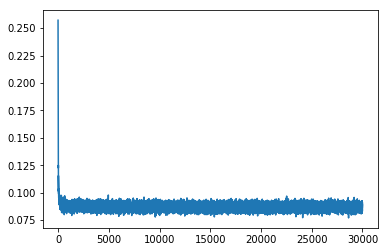

In [18]:
plt.plot( range(len(ae_model_d2['train_losses_list'])) , ae_model_d2['train_losses_list'])

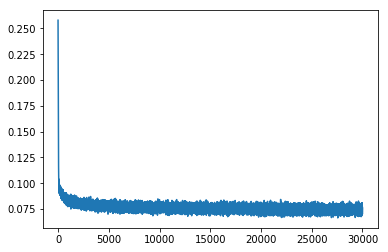

In [19]:
plt.plot( range(len(ae_model_d10['train_losses_list'])) , ae_model_d10['train_losses_list'])

In [20]:
import numpy as np
z = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [21]:
b = z.rsample(sample_shape = [1,20])

In [22]:
b

tensor([[[-0.2836,  0.5951],
         [ 0.8497,  0.9720],
         [ 1.0589,  0.8415],
         [ 1.8905,  0.2696],
         [ 0.8420,  0.8449],
         [ 0.2377,  0.6407],
         [-0.2392,  1.1754],
         [-1.0008, -0.0940],
         [-0.2731, -0.5785],
         [ 0.0157, -0.9225],
         [ 0.1879,  0.1147],
         [ 0.6287,  0.0021],
         [ 0.2631,  1.2153],
         [ 0.8276, -0.6947],
         [ 0.3844, -0.8376],
         [ 1.3818,  1.8331],
         [ 0.7452, -0.2044],
         [ 1.2887, -0.1037],
         [-0.2214,  0.0667],
         [ 0.2631,  0.5161]]])

In [23]:
 b = ae_model_d2['model'].generate_samples(20)

In [24]:
b.size()

torch.Size([20, 784])

In [25]:
%reload_ext autoreload
ae_model_d2['model'].generate_samples(5).shape

torch.Size([5, 784])

### Оценка качества моделей
Визуальная оценка генерируемых объектов

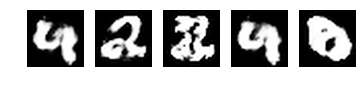

In [26]:
%reload_ext autoreload
show_images(ae_model_d2['model'].generate_samples(5))

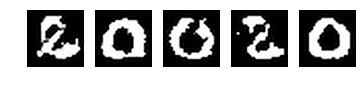

In [27]:
%reload_ext autoreload
show_images(ae_model_d10['model'].generate_samples(5))

Визуализация латентного пространства (с точки зрения декодера)

In [28]:
def draw_manifold_ae(model):
    generator = lambda z: model.decode(torch.from_numpy(z).float()).view(28, 28).data.numpy()
    return draw_manifold(generator)

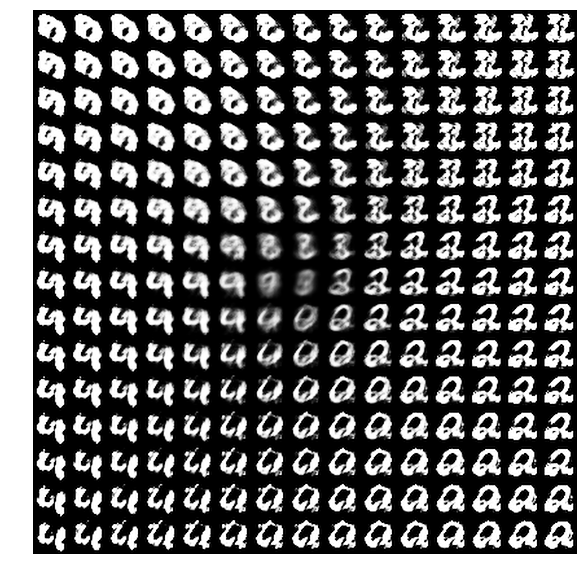

In [29]:
draw_manifold_ae(ae_model_d2['model'])

Визуализация латентного пространства (с точки зрения энкодера)

C:\Apps\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


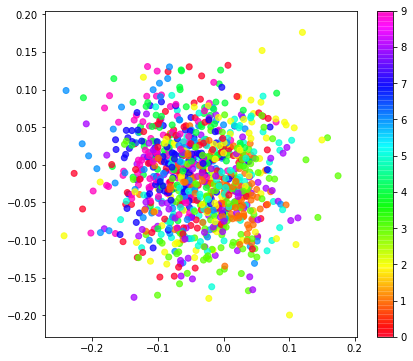

In [30]:
draw_latent_space(test_data.tensors[0][::10], test_data.tensors[1][::10],
                  lambda data: ae_model_d2['model'].encode(data).detach())

C:\Apps\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


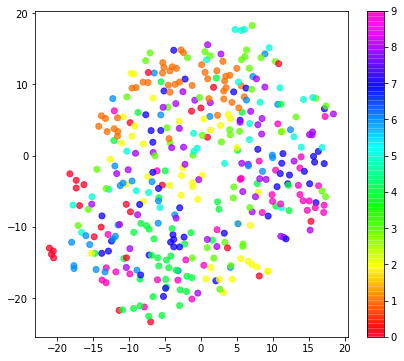

In [31]:
ae_encoder_d10 = lambda data: TSNE().fit_transform(ae_model_d10['model'].encode(data).data.numpy())
draw_latent_space(test_data.tensors[0][::25], test_data.tensors[1][::25], ae_encoder_d10)

## Автокодировщик: теперь вариационный!

В качестве функции потерь используем бинарную кроссэнтропию.
Это означает, что мы предполагаем, что каждый пискель - бинарная случайная величина.
Генеративная сеть выдает вероятность каждого пикселя быть равным $1$.

In [171]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 200)
        self.fc21 = nn.Linear(200, 20)
        self.fc22 = nn.Linear(200, 20)
        self.fc3 = nn.Linear(20, 200)
        self.fc4 = nn.Linear(200, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

    


In [172]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [173]:






def train(epoch):
    model.train()
    train_loss = 0
    dataloader = DataLoader(train_data, batch_size=100, shuffle=True)
    
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))


In [174]:
device = 'cuda'
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [178]:
%time
for epoch in range(1, 10 + 1):
        train(epoch)

Wall time: 0 ns
Train Epoch: 1 [0/60000 (0%)]	Loss: 93.603076
====> Epoch: 1 Average loss: 95.8147
Train Epoch: 2 [0/60000 (0%)]	Loss: 94.292852
====> Epoch: 2 Average loss: 94.4400
Train Epoch: 3 [0/60000 (0%)]	Loss: 93.681221
====> Epoch: 3 Average loss: 93.3788
Train Epoch: 4 [0/60000 (0%)]	Loss: 95.397783
====> Epoch: 4 Average loss: 92.4779
Train Epoch: 5 [0/60000 (0%)]	Loss: 90.385352
====> Epoch: 5 Average loss: 91.7751
Train Epoch: 6 [0/60000 (0%)]	Loss: 94.647646
====> Epoch: 6 Average loss: 91.1620
Train Epoch: 7 [0/60000 (0%)]	Loss: 94.161934
====> Epoch: 7 Average loss: 90.6343
Train Epoch: 8 [0/60000 (0%)]	Loss: 90.619219
====> Epoch: 8 Average loss: 90.1712
Train Epoch: 9 [0/60000 (0%)]	Loss: 87.232070
====> Epoch: 9 Average loss: 89.7464
Train Epoch: 10 [0/60000 (0%)]	Loss: 89.130732
====> Epoch: 10 Average loss: 89.4207


In [179]:
model.eval()
with torch.no_grad():
    sample = torch.randn(20, 20).to(device)
    sample = model.decode(sample).cpu()
    sample = sample.view(20, 1, 28, 28)

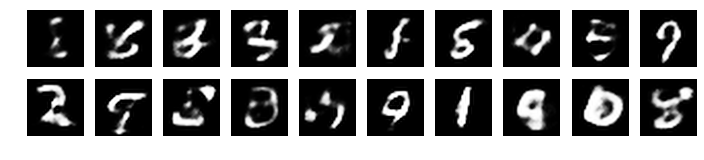

In [180]:
show_images(sample)

In [13]:
d = 2
n = 10 
K = 5

In [42]:
m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
mu = m.rsample(sample_shape = [n,d]).squeeze(2)

sigma = abs(m.rsample(sample_shape = [n,d]).squeeze(2))
distr = (mu , sigma)

In [43]:
distr[1]

tensor([[0.0609, 0.2087],
        [0.4908, 0.9118],
        [0.7826, 0.2126],
        [0.8414, 1.1777],
        [1.3158, 0.5212],
        [0.9876, 0.9771],
        [0.5627, 0.3403],
        [0.7428, 0.2393],
        [1.4357, 0.9674],
        [1.4103, 1.9843]])

In [44]:
n = distr[0].shape[0]
prior  = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(d), torch.eye(d))

b = prior.rsample(sample_shape = [K,]).squeeze(0)

In [45]:
b = b.repeat(n,1,1)



In [59]:
n = b.view(n*K , d)

In [47]:
sigma = sigma.repeat(5,1,1).permute(0,1,2)

In [51]:
sigma = sigma.permute(1,0,2)

In [55]:
mu = mu.repeat(5,1,1).permute(1,0,2)

In [60]:
n.shape

torch.Size([50, 2])

In [58]:
b.shape

torch.Size([10, 5, 2])

In [56]:
l = b * sigma + mu

In [80]:
 z = mu + x * sigma[i]

torch.Size([5, 10])

In [57]:
l.shape

torch.Size([10, 5, 2])

In [12]:
%reload_ext autoreload
from models import log_likelihood, log_mean_exp, kl

In [13]:
%load_ext autoreload
%reload_ext autoreload
from models import VAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Оценки функции потерь

In [14]:
%reload_ext autoreload
from models import gaussian_log_pdf, compute_log_likelihood_monte_carlo, compute_log_likelihood_iwae

### Обучение модели

In [32]:
def log_mean_exp(data):
    """
    Возвращает логарифм среднего по последнему измерению от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Tensor - тензор размера n_1 x n_2 x ... x n_K.
    Возвращаемое значение: Tensor, тензор размера n_1 x n_2 x ,,, x n_{K - 1}.
    """
    return torch.log(torch.mean(torch.exp(data) , -1 ) + 1e-7)

In [33]:
def log_likelihood(x_true, x_distr):
    """
    Вычисляет логарфм правдоподобия объектов x_true для индуцированного
    моделью покомпонентного распределения Бернулли.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!
    Подсказка: делить логарифм правдоподобия на число компонент объекта не надо.

    Вход: x_true, Tensor - матрица объектов размера n x D.
    Вход: x_distr, Tensor - тензор параметров распределений Бернулли
    размера n x K x D.
    Выход: Tensor, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    # ваш код здесь
    n , K  ,D = x_distr.shape
    a = torch.log(1-x_distr)*(1 - x_true).view([n, 1, D])
    b = torch.log(x_distr)*x_true.view([n, 1, D])
    
    return torch.sum(a + b, dim = 2)


In [34]:
def kl(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Tensor, Tensor). Каждый Tensor - матрица размера n x d.
    Первый - mu, второй - sigma.
    Вход: p_distr, tuple(Tensor, Tensor). Аналогично.
    Возвращаемое значение: Tensor, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    p_mu, p_sigma = p_distr
    q_mu, q_sigma = q_distr
    n , d = p_mu.shape
    # ваш код здесь
    return 0.5*torch.sum((q_sigma/p_sigma)**2 + 2*torch.log(p_sigma/q_sigma) + (p_mu-q_mu)*(p_mu-q_mu)/(p_sigma**2) + d, dim = 1)


In [35]:
class VAE(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.proposal_network = nn.Sequential(
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
        )
        self.proposal_mu_head = nn.Linear(200, self.d)
        self.proposal_sigma_head = nn.Linear(200, self.d)
        self.generative_network = nn.Sequential(
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            nn.Sigmoid()
        )

    def proposal_distr(self, x):
        """
        Генерирует предложное распределение на z.
        Подсказка: областью значений sigma должны быть положительные числа.
        Для этого при генерации sigma следует использовать softplus (!) в качестве
        последнего преобразования.
        Вход: x, Tensor - матрица размера n x D.
        Возвращаемое значение: tuple(Tensor, Tensor),
        Каждый Tensor - матрица размера n x d.
        Первый - mu, второй - sigma.
        """
        # ваш код здесь
        x = self.proposal_network(x)
        
        
        bam = torch.nn.Softplus()
        
        mu = self.proposal_mu_head(x)
        sigma = bam(self.proposal_sigma_head (x))
        return mu, sigma

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Tensor, Tensor),
        Каждый Tensor - матрица размера n x d.
        Первый - mu, второй - sigma.
        """
        # ваш код здесь
        mu = torch.zeros([n, self.d])
        sigma = torch.ones([n, self.d])
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Tensor, Tensor). Каждое Tensor - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Tensor, матрица размера n x K x d.
        """
        # ваш код здесь
        
        n , d = distr[0].shape
        mu, sigma = distr
        
        b = torch.randn(n, K, d)
        z = b*sigma.view(n,1,d) + mu.view(n,1,d)
        return z
        

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Tensor - тензор n x K x d латентных представлений.
        Возвращаемое значение: Tensor, тензор параметров распределения
        Бернулли размера n x K x D.
        """
       
        # ваш код здесь
        n , K, d = z.shape
        #z = z.reshape( n*K , d)
        g = self.generative_network(z)
        #g = g.reshape(n,K, self.D)
        g = torch.clamp(g,min=0.01,max=0.99)
        return g
        


    def batch_loss(self, batch):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Требуется вернуть усреднение вариационных нижних оценок объектов батча.
        Вход: batch, FloatTensor - матрица объектов размера n x D.
        Возвращаемое значение: Tensor, скаляр - вариационная нижняя оценка логарифма
        правдоподобия по батчу.
        """
        # ваш код здесь
        n , D = batch.shape
        pri_distr = self.prior_distr(n)
        
        pr_distr = self.proposal_distr(batch)
        distr = self.generative_distr(self.sample_latent(pr_distr))
        
        return torch.mean(torch.mean(log_likelihood(batch, distr), dim = 1) - kl(pr_distr, pri_distr), dim = 0)


    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x D.
        """
        # ваш код здесь
        z = self.generative_distr(self.sample_latent(self.prior_distr(1), num_samples))
        #print(z.shape)
        z = z.view([num_samples, -1])
        #print(z.shape)
        return torch.bernoulli(z)


In [36]:
def gaussian_log_pdf(distr, samples):
    """
    Функция вычисляет логарифм плотности вероятности в точке относительно соответствующего
    нормального распределения, заданного покомпонентно своими средним и среднеквадратичным отклонением.
    Вход: distr, tuple(Tensor, Tensor). Каждый Tensor - матрица размера n x d.
    Первый - mu, второй - sigma.
    Вход: samples, Tensor - тензор размера n x K x d сэмплов в скрытом пространстве.
    Возвращаемое значение: Tensor, матрица размера n x K, каждый элемент которой - логарифм
    плотности вероятности точки относительно соответствующего распределения.
    """
    mu, sigma = distr
    n , K, d = samples.shape
    # ваш код здесь
    b = -torch.sum(((samples - mu.reshape([n, 1, d]))**2)/sigma.reshape([n, 1, d])**2, dim = 2)+ d*(math.log(2) + math.log(math.pi))
    z = -torch.sum(torch.log(sigma), dim = 1).reshape(n, 1)
    return 0.5*b + z

In [37]:
def compute_log_likelihood_monte_carlo(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Монте-Карло.
    Оценка логарифма правдоподобия модели должна быть усреднена по всем объектам батча.
    Подсказка: не забудьте привести возращаемый ответ к типу float, иначе при вычислении
    суммы таких оценок будет строится вычислительный граф на них, что быстро приведет к заполнению
    всей доступной памяти.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы prior_distr, sample_latent и generative_distr,
    описанные в VAE.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    n , D = batch.shape
    
    pri_distr = model.prior_distr(n)
    x_distr = model.generative_distr(model.sample_latent(pri_distr, K = K))
    return torch.mean(log_mean_exp(log_likelihood(batch, x_distr)), dim = 0)

In [38]:

def compute_log_likelihood_iwae(batch, model, K):
    """
    Функция, оценку IWAE логарифма правдоподобия вероятностной модели по батчу.
    Оценка логарифма правдоподобия модели должна быть усреднена по всем объектам батча.
    Подсказка: не забудьте привести возращаемый ответ к типу float, иначе при вычислении
    суммы таких оценок будет строится вычислительный граф на них, что быстро приведет к заполнению
    всей доступной памятыи.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы prior_distr, proposal_distr, sample_latent и generative_distr,
    описанные в VAE.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    n , D = batch.shape
    propos_distr = model.proposal_distr(batch)
    prior_distr = model.prior_distr(n)
    
    
    
    z = model.sample_latent(propos_distr, K = K)
    y = model.generative_distr(z)
    
    g_prior = gaussian_log_pdf(prior_distr, z)
    g_propos = gaussian_log_pdf(propos_distr, z)
    ll  = log_likelihood(batch, y)
    
    return torch.mean(log_mean_exp(ll + g_prior - g_propos), dim = 0)

In [ ]:
vae_tests = [
    {
        'name': 'MC',
        'func': lambda model:
                model_test_loss(lambda batch:
                                compute_log_likelihood_monte_carlo(batch, model, K=10),
                                max_batches=20)
    },
    {
        'name': 'IS',
        'func': lambda model:
                model_test_loss(lambda batch:
                                compute_log_likelihood_iwae(batch, model, K=10),
                                max_batches=20)
    }
]

In [ ]:
%time vae_model_d2 = train_model(VAE(2, 784), tests=vae_tests, num_epochs=50)

Train loss: -217.00494384765625 Batch 100 of 600                                                                                                     
Train loss: -194.13613891601562 Batch 200 of 600                                                                                                     
Train loss: -196.05609130859375 Batch 300 of 600                                                                                                     
Train loss: -190.09690856933594 Batch 400 of 600                                                                                                     
Train loss: -176.37066650390625 Batch 500 of 600                                                                                                     
Train loss: -184.8888702392578 Batch 600 of 600                                                                                                     
Train loss: -175.64712524414062 Batch 100 of 600                                                     

In [ ]:
%time vae_model_d10 = train_model(VAE(10, 784), tests=vae_tests, num_epochs=50)

### Оценка качества модели

Визуальная оценка генерируемых объектов

In [ ]:
show_images(vae_model_d2['model'].generate_samples(20))

In [ ]:
show_images(vae_model_d10['model'].generate_samples(20))

Визуализация латентного пространства (с точки зрения декодера)

In [ ]:
def draw_manifold_vae(model):
    generator = lambda z: model.generative_distr(torch.from_numpy(z).unsqueeze(1).float()).view(28, 28).data.numpy()
    return draw_manifold(generator)

In [ ]:
draw_manifold_vae(vae_model_d2['model'])

Визуализация латетного пространства (с точки зрения энкодера)

In [ ]:
vae_encoder = lambda data, model: model.sample_latent(model.proposal_distr(data))[:, 0].detach()
draw_latent_space(test_data.tensors[0][::10], test_data.tensors[1][::10],
                  lambda data: vae_encoder(data, vae_model_d2['model']))

In [ ]:
vae_encoder_d10 = lambda data: TSNE().fit_transform(vae_encoder(data, vae_model_d10['model']).data.numpy())
draw_latent_space(test_data.tensors[0][::25], test_data.tensors[1][::25], vae_encoder_d10)

### Оценки логарифма правдоподобия на тестовых данных

In [ ]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('VAE, Monte-Carlo, $d = 2$', 'MC', vae_model_d2),
    ('VAE, Monte-Carlo, $d = 10$', 'MC', vae_model_d10),
    ('VAE, Importance Sampling, $d = 2$', 'IS', vae_model_d2),
    ('VAE, Importance Sampling, $d = 10$', 'IS', vae_model_d10),
]:
    data = [x[name] for x in model['test_results']]
    x_labels = (1 + np.arange(len(data))) / 6
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation, 10 samples')
plt.legend()
pass

In [ ]:
test_results = []
for K in [1, 5, 10, 50, 100, 500, 1000]:
    print('K =', K, flush=True)
    vae_tests_sampling = [
        {
            'name': 'D10MC',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_monte_carlo(batch, vae_model_d10['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        },
        {
            'name': 'D10IWAE',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_iwae(batch, vae_model_d10['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        },
        {
            'name': 'D2MC',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_monte_carlo(batch, vae_model_d2['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        },
        {
            'name': 'D2IWAE',
            'func': model_test_loss(lambda batch:
                                    compute_log_likelihood_iwae(batch, vae_model_d2['model'], K=K),
                                    batch_size=10,
                                    max_batches=50)
        }
    ]
    cur_test_results = {'K': K}
    for test in vae_tests_sampling:
        cur_test_results[test['name']] = test['func']
    test_results.append(cur_test_results)

In [ ]:
plt.figure(figsize=(9, 6))
for label, name in [
    ('VAE, Monte-Carlo, $d = 2$', 'D2MC'),
    ('VAE, Importance Sampling, $d = 2$', 'D2IWAE'),
    ('VAE, Monte-Carlo, $d = 10$', 'D10MC'),
    ('VAE, Importance Sampling, $d = 10$', 'D10IWAE'),
]:
    data = [x[name] for x in test_results]
    x_labels = [x['K'] for x in test_results]
    plt.plot(x_labels, data, label=label)
plt.xlabel('Number of samples')
plt.xscale('log')
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы

Место для ваших выводов, наблюдений, гипотез.